In [1]:
good_model_list = [
    "doubao-1-5-pro-256k-250115",
    "gemini-2.5-flash-preview-04-17",
    "gpt-4.1-2025-04-14",
    "gpt-4.1-mini-2025-04-14",
    "o4-mini",
]

In [2]:
from itertools import combinations_with_replacement

In [3]:
generator1 = list(combinations_with_replacement(good_model_list, 2))

In [4]:
from pathlib import Path

In [ ]:
base_log_dir = "logs_hinted"
eta=0.4
horses_per_player = 7

In [6]:
base_log_path = Path(base_log_dir)

In [7]:
import pandas as pd

In [8]:
pd_dicts = dict()
for combinator in generator1:
    read_file_dir = base_log_path / (" ".join(combinator) + ".csv")
    pd_dicts[combinator] = pd.read_csv(read_file_dir, header=[0], index_col=[0])

In [9]:
import ast

In [10]:
for combinator in pd_dicts.keys():
    pd_dicts[combinator] = pd_dicts[combinator].map(func=ast.literal_eval, na_action="ignore")

In [11]:
from itertools import count

In [12]:
import numpy as np

In [13]:
import horse_environment

In [14]:
import math

In [15]:
pd_dicts[list(pd_dicts.keys())[0]]

,rand_values,choices
0,"[2, 5]","[6, 5]"
1,"[5, 1]","[5, 6]"
2,"[4, 1]","[4, 4]"
3,"[2, 2]","[3, 3]"
4,"[1, 2]","[2, 2]"
...,...,...
66,"[2, 1]","[3, 3]"
67,"[1, 0]","[2, 2]"
68,"[1, 0]","[1, 1]"
69,"[0, 0]","[0, 0]"


In [16]:
def get_win_rate(df: pd.DataFrame, horses_per_player: int, eta: float):
    player_count:int = len(df.iloc[0,0])
    tournaments_results = []
    env1 = horse_environment.HorseRaceGame(players=[None] * player_count, 
        horses_per_player=horses_per_player)
    log_likelihood_each_tournament = [[0.0] * player_count] # stuff a base accumulator
    idxer = 0
    for rounder in df.index[:-1]:
        idxer += 1
        _, _, terminated, _, _ = env1.step(df.loc[rounder, "choices"])
        if terminated:
            total_rewards = env1.get_total_rewards()
            max_reward = np.max(total_rewards)
            winnity = (total_rewards == max_reward)
            end_reward = winnity / winnity.sum()
            tournaments_results.append(end_reward)
            env1 = horse_environment.HorseRaceGame(players=[None] * player_count, 
                horses_per_player=horses_per_player)
            log_likelihood_each_tournament.append([0.0] * player_count)
            idxer = 0
        else:
            for player in range(player_count):
                if (df.loc[rounder, "rand_values"][player] == df.loc[rounder, "choices"][player]):
                    log_likelihood_each_tournament[-1][player] += (math.log(1 - (horses_per_player - idxer) / (horses_per_player - idxer + 1) * eta) - math.log(1 / (horses_per_player - idxer + 1)))
                else:
                    log_likelihood_each_tournament[-1][player] += (math.log(eta / (horses_per_player - idxer + 1)) - math.log(1 / (horses_per_player - idxer + 1)))
    total_wins = [
        sum(tournament_result[player] for tournament_result in tournaments_results)
        for player in range(player_count)
    ]
    total_likelihoods = [
        sum(tournament_result[player] for tournament_result in log_likelihood_each_tournament)
        for player in range(player_count)
    ]
    avg_likelihood_per_tournament = [total_likelihood / (df.shape[0] - 1) * horses_per_player for total_likelihood in total_likelihoods]
    return total_wins, tournaments_results, total_likelihoods, avg_likelihood_per_tournament, log_likelihood_each_tournament

    

In [17]:
total_wins_dict = dict()
loglikelihood_per_tournament = dict()
avg_likelihood_dict = dict()
total_likelihood_dict = dict()
for combinator in pd_dicts.keys():
    total_wins_dict[combinator], _, total_likelihood_dict[combinator], avg_likelihood_dict[combinator], loglikelihood_per_tournament[combinator] = get_win_rate(
        pd_dicts[combinator], horses_per_player=horses_per_player, eta=eta)

In [18]:
loglikelihood_per_tournament

{('doubao-1-5-pro-256k-250115',
  'doubao-1-5-pro-256k-250115'): [[0.33120122636527716,
   0.03564509748259004], [-1.6691029947558351, -3.7929962990065054], [1.193097886173633,
   -4.11145003012504], [-5.497744391244931,
   -1.109487206820413], [-2.1655398810697264, -4.11145003012504], [-5.497744391244931,
   -2.4067019378866146], [-2.4067019378866146,
   -1.6529301355102337], [-5.497744391244931, -0.26663577439034325], [-1.8088649371309935,
   -4.11145003012504], [-4.11145003012504, -3.357678227748659], [0.0, 0.0]],
 ('doubao-1-5-pro-256k-250115',
  'gemini-2.5-flash-preview-04-17'): [[0.33120122636527716,
   -2.4067019378866146], [-1.6691029947558351,
   -3.7929962990065054], [1.193097886173633, -4.11145003012504], [-5.497744391244931,
   -1.109487206820413], [-2.1655398810697264,
   -4.11145003012504], [-5.497744391244931, -2.4067019378866146], [-2.4067019378866146,
   -1.6529301355102337], [-5.497744391244931,
   -1.6529301355102337], [-1.8088649371309935, -4.11145003012504], [-4.1

In [19]:
pd_dicts[("doubao-1-5-pro-256k-250115", "doubao-1-5-pro-256k-250115")].index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
      dtype='int64')

In [20]:
good_model_list = [
    "doubao-1-5-pro-256k-250115",
    "gpt-4.1-mini-2025-04-14",
    "gpt-4.1-2025-04-14",
    "o4-mini",
    "gemini-2.5-flash-preview-04-17",
]

# plotting

In [21]:
def wrap_labels(labels, max_length=10):
    """
    Wraps tick labels that exceed a certain length with newline characters.
    
    Parameters:
    - labels: List of str, original labels for matplotlib ticks.
    - max_length: Integer, maximum length of each line before wrapping.
    
    Returns:
    - List of str, with '\n' inserted where lines exceed max_length.
    """
    wrapped_labels = []
    for label in labels:
        if len(label) > max_length:
            # Calculate how many parts we need based on max_length
            parts = [label[i:i + max_length] for i in range(0, len(label), max_length)]
            # Join parts with newline characters
            wrapped_label = "\n".join(parts)
            wrapped_labels.append(wrapped_label)
        else:
            wrapped_labels.append(label)
    return wrapped_labels

In [22]:
import numpy as np

# initialize a 5x5 empty matrix for storing the results
result_matrix = np.zeros((5, 5), dtype=float)



# fill the matrix
for key, value in total_wins_dict.items():
    i = good_model_list.index(key[0])
    j = good_model_list.index(key[1])
    result_matrix[i, j] = value[1] - value[0]
    if j != i:
        result_matrix[j, i] = value[0] - value[1]

In [23]:
result_matrix

array([[ 0., -2.,  0.,  9.,  0.],
       [ 2., -4.,  0.,  9.,  2.],
       [ 0.,  0., -1.,  6.,  3.],
       [-9., -9., -6., -2., -1.],
       [ 0., -2., -3.,  1.,  1.]])

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define the data arrays
def plot_diagonal(n, result0, result1, y_tics, x_tics, font_color, plot_epsilon=0, plot_size=6):
    # Determine global min and max for color normalization
    vmin = -5
    vmax = 8

    # Create normalization and colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(plot_size * 1.2, plot_size))

    # Draw each cell with split triangles
    for i in range(n):
        for j in range(n):
            # Coordinates for the current cell
            x, y = j, i
            
            # Lower-left triangle (result0)
            ur_triangle = np.array([[x + plot_epsilon, y + 2 * plot_epsilon], [x + plot_epsilon, y + 1 - plot_epsilon], [x+1 - 2 * plot_epsilon, y + 1 - plot_epsilon]])
            ax.add_patch(Polygon(ur_triangle, closed=True, color=cmap(norm(result0[i, j]))))
            

            ax.text(x + 0.33, y + 0.67, f"{result0[i, j]:.1f}",
                ha='center', va='center', color=font_color, fontsize=plot_size * 3)



            # Upper-right triangle (result1)
            ll_triangle = np.array([[x + 2 * plot_epsilon, y + plot_epsilon], [x+1 - plot_epsilon, y + plot_epsilon], [x+1 - plot_epsilon, y+ 1 - 2 * plot_epsilon]])
            ax.add_patch(Polygon(ll_triangle, closed=True, color=cmap(norm(result1[i, j]))))

            
            ax.text(x + 0.67, y + 0.33, f"{result1[i, j]:.1f}",
                ha='center', va='center', color=font_color, fontsize=plot_size * 3)

    # Adjust axis limits and invert y-axis
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.invert_yaxis()

    # Set ticks at the center of each cell
    ax.set_xticks(np.arange(n) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)
    
    ax.set_xticklabels(wrap_labels(x_tics), rotation=90, ha='left')
    ax.set_yticklabels(wrap_labels(y_tics))


    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')


    # Add colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax)

    # Add labels and title (optional)
    ax.set_xlabel('Model')
    ax.set_ylabel('Model')
    ax.set_title('')

    plt.tight_layout()

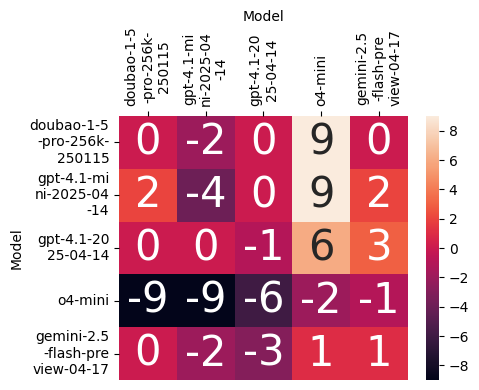

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating the heatmap
plt.figure(figsize=(5, 4))
ax = sns.heatmap(result_matrix, annot=True, cmap='rocket', xticklabels=wrap_labels(good_model_list), yticklabels=wrap_labels(good_model_list),  annot_kws={'size': 30})
ax.xaxis.set_ticks_position('top')  # Move the x-axis ticks to the top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xlabel('Model')
plt.ylabel('Model')

# Tilt the x-axis and y-axis labels to 45 degrees
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(base_log_path / f"gain_{base_log_dir}.png")

In [26]:
import numpy as np

# initialize a 5x5 empty matrix for storing the results
result0 = np.zeros((5, 5), dtype=float)
result1 = np.zeros((5, 5), dtype=float)


# fill the matrix
for key, value in avg_likelihood_dict.items():
    i = good_model_list.index(key[0])
    j = good_model_list.index(key[1])
    result0[i, j] = value[0]
    result1[i, j] = value[1]
    if (i != j):
        result0[j, i] = value[1]
        result1[j, i] = value[0]

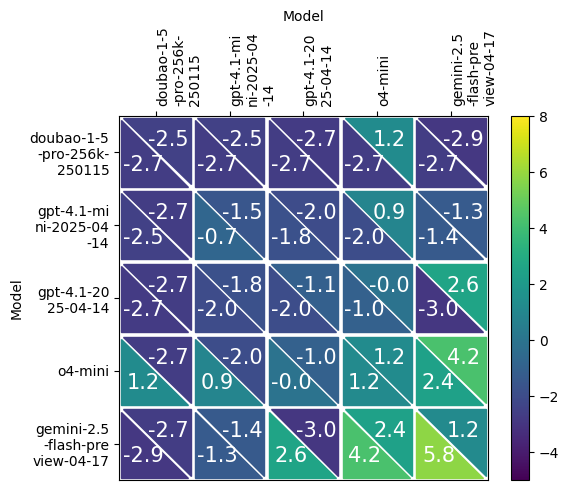

In [27]:
plot_diagonal(len(good_model_list), result0, result1, good_model_list, good_model_list, "white", 0.03, 5)
plt.savefig(base_log_path / f"randomness_{base_log_dir}.png")